# 1. Install Dependencies

In [28]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# 2. Load Data

### 2.1 Load Images

In [29]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [30]:
# Load train_images
train_images = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [31]:
#view an image
sample= train_images.as_numpy_iterator().next()

In [32]:
plt.imshow(sample)

In [33]:
#load test_images
test_images = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [34]:
#load validation images
val_images = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [35]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
    label = json.load(f)
  return [label['keypoints']]

In [36]:
#load train labels
train_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [37]:
#load test labels
test_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [38]:
# load validation labels
val_labels = tf.data.Dataset.list_files('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

### 2.3 Combine Labels and Images

In [39]:
# combine train images and train labels
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [40]:
# combine test images and test labels
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [41]:
# combine val images and val labels
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1300)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [42]:
data_samples= val.as_numpy_iterator().next()

In [43]:
data_samples[1][0]

In [44]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = data_samples[0][idx]
    sample_coords = data_samples[1][0][idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (0,0,255), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [46]:
model = Sequential([
    Input(shape=(250,250,3)),
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 256)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 1, 1, 4)          

### 3.2 Setup Losses and Optimizer

In [48]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [49]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [50]:
X, y = train.as_numpy_iterator().next()

In [51]:
X.shape

In [52]:
scores = model.predict(X)

In [53]:
scores

### 3.4 Train the Model

In [54]:
# Train for 100 epochs
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
420/420 [==============================] - 315s 634ms/step - loss: 0.8267 - val_loss: 0.0233
Epoch 2/10
420/420 [==============================] - 291s 626ms/step - loss: 0.0231 - val_loss: 0.0242
Epoch 3/10
420/420 [==============================] - 288s 623ms/step - loss: 0.0224 - val_loss: 0.0234
Epoch 4/10
420/420 [==============================] - 309s 672ms/step - loss: 0.0218 - val_loss: 0.0232
Epoch 5/10
420/420 [==============================] - 289s 626ms/step - loss: 0.0212 - val_loss: 0.0241
Epoch 6/10
420/420 [==============================] - 290s 625ms/step - loss: 0.0208 - val_loss: 0.0231
Epoch 7/10
420/420 [==============================] - 291s 628ms/step - loss: 0.0200 - val_loss: 0.0247
Epoch 8/10
420/420 [==============================] - 290s 629ms/step - loss: 0.0187 - val_loss: 0.0248
Epoch 9/10
420/420 [==============================] - 290s 628ms/step - loss: 0.0178 - val_loss: 0.0260
Epoch 10/10
420/420 [==============================] - 290s 630m

# 4. Review Performance

### 4.1 View Loss Plots

In [ ]:
hist.history

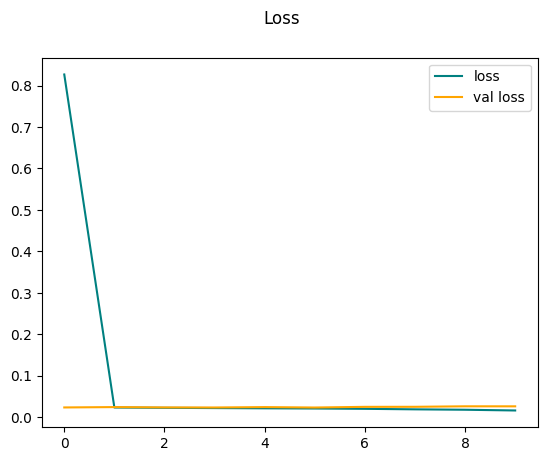

In [56]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2 Make Prediction on test set

In [57]:
test_data = test.as_numpy_iterator()

In [58]:
test_sample = test_data.next()

In [59]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 3s 3s/step


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)

    ax[idx].imshow(sample_image)

### 4.3 Save the Model

In [61]:
from tensorflow.keras.models import load_model

In [62]:
model.save('/content/drive/MyDrive/ML projects/Computer Vision/Eye tracker ( iris detection)/eyetrackerresnet.h5')